In [77]:
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel, nmf
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [48]:
news = pd.read_csv('./data/en_interim_01_05_DV_IN_with_full_texts.csv', index_col=False)

In [49]:
news_april_may = pd.read_csv('./data/en_April_May_with_full_texts.csv', index_col=False)

In [38]:
news_april_may_df = news_april_may[["Date_published", "URL", "Headline", "text"]]

In [39]:
news_df = news[["DATEADDED","SOURCEURL","title", "text"]]

In [40]:
news_april_may_articles = news_april_may_df.rename(
  columns={
    "Date_published" : 'DATEADDED',
    "URL" : 'SOURCEURL',
    "Headline" : 'title'
  }
)

In [43]:
news_april_may_articles.columns

Index(['DATEADDED', 'SOURCEURL', 'title', 'text'], dtype='object')

In [44]:
news_df.columns

Index(['DATEADDED', 'SOURCEURL', 'title', 'text'], dtype='object')

In [45]:
merged_data = pd.concat([news_df, news_april_may_articles])

In [46]:
merged_data.head()

,DATEADDED,SOURCEURL,title,text
0,20200101001500,https://timesofindia.indiatimes.com/city/surat...,who killed dishit wife two others set to walk ...,"Surat: Who killed Dishit Jariwala ? Wife, two ..."
1,20200101010000,https://www.sheltonherald.com/news/crime/artic...,Lawsuit Famed Jesuit abused boy 1 000 times 14...,NaN
2,20200101041500,http://www.canindia.com/caa-protests-shia-cler...,caa protests shia cleric kalbe jawad to meet f...,\n\n\n\n\n\n\n\n\n\n\n\n\n\nCAA protests: Shia...
3,20200101063000,https://www.business-standard.com/article/pti-...,entry of 2 young women in sabarimala rahul gan...,\n\n\n\n\n\n\n\nEntry of 2 young women in Sab...
4,20200101064500,https://thehimalayantimes.com/nepal/minister-g...,minister gokul prasad baskota pledges to book ...,\n\n\n\n\n\n\n\n\nMinister Gokul Prasad Baskot...


In [50]:
nlp = spacy.load('en_core_web_sm')
def normalize_text(text):
  text = str(text)
  tm1 = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
  tm2 = re.sub('<code>.*?</code>', '', tm1, flags=re.DOTALL)
  tm3 = re.sub('<[^>]+>©', '', tm1, flags=re.DOTALL)
  return tm3.replace("\n", "")

news_text = merged_data[merged_data.text != "Empty"]

news_text['text_norm'] = news_text['text'].apply(normalize_text)

In [51]:
punctuations = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~©'
def cleanup_text(docs, logging=False):
    texts = []
    doc = nlp(docs, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stop_words and tok not in punctuations]
    tokens = ' '.join(tokens)
    texts.append(tokens)
    return pd.Series(texts)
news_text['full_text'] = news_text['text_norm'].apply(lambda x: cleanup_text(x, False))

In [52]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = ' '.join(re.sub("(\w+:\/\/\S+)", " ", sent).split()) # removal of address
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove apostrophe
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  
        
# Convert to list
data = news_text.full_text.values.tolist()
data_words = list(sent_to_words(data))

In [53]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [90]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [91]:
pprint(lda_model.print_topics())

[(0,
  '0.052*"state" + 0.035*"covid" + 0.034*"people" + 0.034*"report" + '
  '0.032*"worker" + 0.029*"patient" + 0.028*"death" + 0.027*"migrant" + '
  '0.018*"official" + 0.017*"toll"'),
 (1,
  '0.050*"day" + 0.045*"government" + 0.036*"lockdown" + 0.035*"article" + '
  '0.033*"month" + 0.031*"issue" + 0.028*"news" + 0.028*"case" + 0.021*"play" '
  '+ 0.015*"open"'),
 (2,
  '0.456*"free" + 0.085*"release_jnu" + 0.055*"subscribe" + 0.055*"government" '
  '+ 0.047*"student" + 0.023*"labourer" + 0.020*"administration" + '
  '0.012*"district" + 0.011*"nationwide" + 0.011*"support"'),
 (3,
  '0.033*"support" + 0.028*"business" + 0.026*"show" + 0.026*"researcher" + '
  '0.022*"film" + 0.018*"share" + 0.017*"time" + 0.017*"look" + 0.015*"find" + '
  '0.015*"still"'),
 (4,
  '0.000*"afridi" + 0.000*"pcb" + 0.000*"odi" + 0.000*"danish_kaneria" + '
  '0.000*"fielder" + 0.000*"pmc" + 0.000*"almighty" + 0.000*"akhtar" + '
  '0.000*"shoaib" + 0.000*"supremely"'),
 (5,
  '0.029*"blame" + 0.028*"tru

In [92]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.7701,"test, covid, case, day, positive, domestic, fl...","[set, walk, set, walk, freethis, story, surat,..."
1,1,0.0,0.1000,"state, covid, people, report, worker, patient,...",[]
2,2,0.0,0.5303,"state, covid, people, report, worker, patient,...","[protest, family, victim, free, hard, confirm,..."
3,3,1.0,0.2956,"day, government, lockdown, article, month, iss...","[young, woman, news, world, test, tax, world, ..."
4,4,7.0,0.3876,"test, covid, case, day, positive, domestic, fl...","[guilty, rape, murder, guilty, rape, guilty, r..."
5,5,9.0,0.3557,"map, work, read, report, people, time, player,...","[young, woman, win, flood, year, eventful, fin..."
6,6,2.0,0.4480,"free, release_jnu, subscribe, government, stud...","[dead, kill, result, businessman, wife, daught..."
7,7,2.0,0.4400,"free, release_jnu, subscribe, government, stud...","[daughter, find, dead, inside, car, result, bu..."
8,8,6.0,0.6898,"video, family, day, home, back, help, old, cal...","[old, woman, private, part, rape, news, dofamo..."
9,9,9.0,0.2700,"map, work, read, report, people, time, player,...","[young, woman, eventful, portalhomee, portal, ..."


In [93]:
df_dominant_topic.shape

(10272, 5)

In [94]:
news_text['Topic_lda'] = df_dominant_topic['Dominant_Topic']

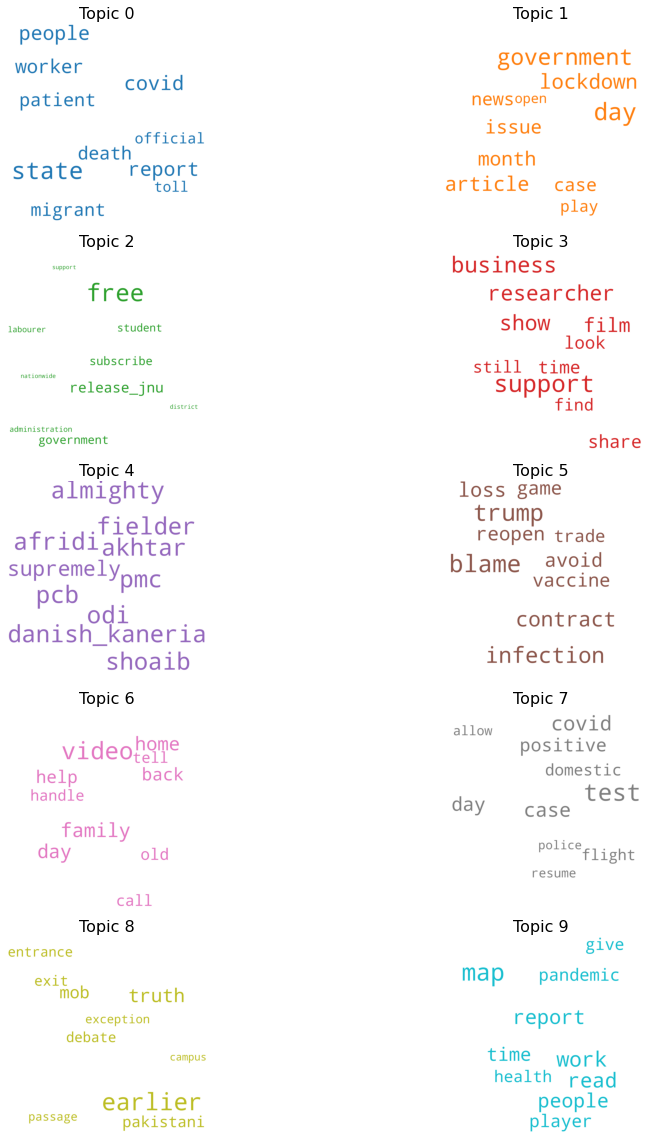

In [114]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=2500,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)
fig, axes = plt.subplots(5, 2, figsize=(16,16), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

# plt.show()

In [106]:
lda_dataset= news_text[news_text['Topic_lda']==7]

In [107]:
lda_dataset.shape

(4780, 8)

# NMF

In [98]:
# Train the model on the corpus.
nmf = gensim.models.nmf.Nmf(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=10, 
                                   random_state=100,
                                   chunksize=10)

In [99]:
pprint(nmf.print_topics())

[(0,
  '0.169*"free" + 0.075*"share" + 0.066*"plastic" + 0.041*"support" + '
  '0.040*"orissapost" + 0.037*"page_orissapost" + 0.025*"october_plastic" + '
  '0.023*"student" + 0.019*"post" + 0.019*"subscribe"'),
 (1,
  '0.051*"new" + 0.027*"year" + 0.026*"day" + 0.023*"share" + 0.018*"reveal" + '
  '0.017*"woman" + 0.016*"protest" + 0.012*"show" + 0.011*"face" + '
  '0.009*"video"'),
 (2,
  '0.062*"case" + 0.026*"convict" + 0.026*"court" + 0.015*"death" + '
  '0.014*"covid" + 0.014*"rape" + 0.013*"report" + 0.011*"victim" + '
  '0.010*"test" + 0.009*"state"'),
 (3,
  '0.078*"woman" + 0.009*"work" + 0.008*"violence" + 0.006*"man" + '
  '0.005*"domestic" + 0.004*"indian" + 0.004*"give" + 0.004*"time" + '
  '0.004*"officer" + 0.004*"gender"'),
 (4,
  '0.177*"free" + 0.079*"share" + 0.070*"plastic" + 0.046*"support" + '
  '0.043*"orissapost" + 0.041*"page_orissapost" + 0.030*"october_plastic" + '
  '0.022*"post" + 0.021*"student" + 0.016*"subscribe"'),
 (5,
  '0.011*"year" + 0.008*"people"

In [100]:
def format_nmf_topics_sentences(model=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(model[corpus]):
        row = row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = nmf.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [101]:
df_topic_sents_keywords_nmf = format_nmf_topics_sentences(model=nmf, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic_nmf = df_topic_sents_keywords_nmf.reset_index()
df_dominant_topic_nmf.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_nmf.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6043,"case, convict, court, death, covid, rape, repo...","[set, walk, set, walk, freethis, story, surat,..."
1,1,6.0,0.3676,"protest, government, people, student, state, p...",[]
2,2,6.0,0.5955,"protest, government, people, student, state, p...","[protest, family, victim, free, hard, confirm,..."
3,3,6.0,0.4495,"protest, government, people, student, state, p...","[young, woman, news, world, test, tax, world, ..."
4,4,6.0,0.7361,"protest, government, people, student, state, p...","[guilty, rape, murder, guilty, rape, guilty, r..."
5,5,4.0,0.9046,"free, share, plastic, support, orissapost, pag...","[young, woman, win, flood, year, eventful, fin..."
6,6,8.0,0.7766,"free, share, plastic, support, orissapost, pag...","[dead, kill, result, businessman, wife, daught..."
7,7,7.0,0.8227,"police, rape, year, old, girl, accuse, woman, ...","[daughter, find, dead, inside, car, result, bu..."
8,8,6.0,0.4982,"protest, government, people, student, state, p...","[old, woman, private, part, rape, news, dofamo..."
9,9,7.0,0.5187,"police, rape, year, old, girl, accuse, woman, ...","[young, woman, eventful, portalhomee, portal, ..."


In [102]:
news_text['Topic_nmf'] = df_dominant_topic_nmf['Dominant_Topic']

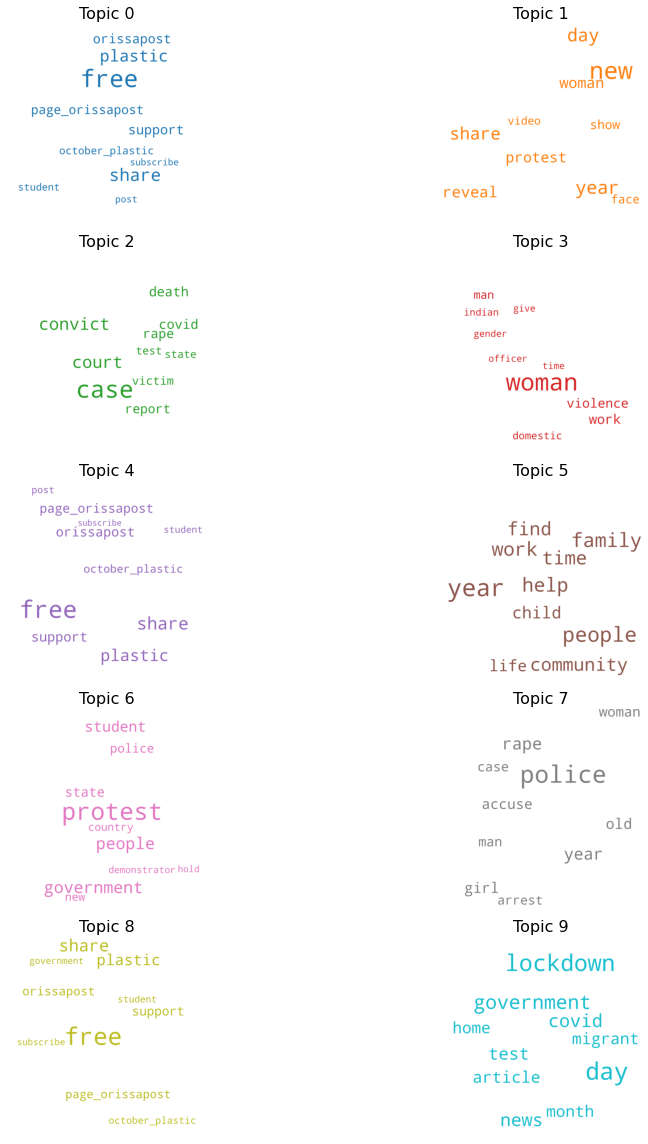

In [103]:
topics_nmf = nmf.show_topics(formatted=False)
fig, axes = plt.subplots(5, 2, figsize=(16,16), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics_nmf[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [111]:
plt.savefig('./news_nmf.png')

<Figure size 432x288 with 0 Axes>

In [104]:
nmf_dataset= news_text[(news_text['Topic_nmf']==2) | (news_text['Topic_nmf']==3) |(news_text['Topic_nmf']==7)]

In [105]:
nmf_dataset.shape

(6935, 8)

In [108]:
nmf_lda = pd.concat([lda_dataset,nmf_dataset])

In [109]:
nmf_lda.shape

(11715, 8)

In [110]:
nmf_lda.to_csv("./en_combined_nmf_lda.csv")